In [1]:
import os,sys
sys.path.append("..")
import numpy as np
import pandas as pd
import ibmseti
import collections
import scipy.io
import matplotlib.pyplot as plt
import commonutils as cu
import PIL
from PIL import Image
import sklearn
import h5py
from sklearn import svm

Using TensorFlow backend.


In [2]:
import keras
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.utils import np_utils

In [3]:
def runLinSVMModel(dataset,C,nDataset,modeltype,printReports=True,gamma=None):
    x_train = dataset['x_train']
    y_train = dataset['y_train']
    x_test = dataset['x_test']
    y_test = dataset['y_test']
    
    # Scaling training and test data
    means = np.mean(x_train,axis=0)
    stddev = np.std(x_train,axis=0)
    # Preventing zero division
    stddev[stddev<1e-3] = 1
    x_train = (x_train - means)/stddev
    x_test = (x_test - means)/stddev
    
    if modeltype=='linSVM':
        lin_clf = svm.LinearSVC(C=C/nDataset,verbose=True,class_weight='balanced')
        lin_clf.fit(x_train, y_train)
        pred_train = lin_clf.predict(x_train)
        pred_test = lin_clf.predict(x_test)
    elif modeltype=='linSVR':
        lin_clf = svm.LinearSVC(C=C/nDataset,verbose=True)
        lin_clf.fit(x_train, y_train)
        pred_train = np.round(lin_clf.predict(x_train))
        pred_test = np.round(lin_clf.predict(x_test))
    elif modeltype=='rbfSVM':
        lin_clf = svm.SVC(C=C/nDataset,gamma=gamma,verbose=True,class_weight='balanced',
                          decision_function_shape='ovr')
        lin_clf.fit(x_train, y_train)
        pred_train = lin_clf.predict(x_train)
        pred_test = lin_clf.predict(x_test)

    train_report = sklearn.metrics.classification_report(y_train,pred_train)
    test_report = sklearn.metrics.classification_report(y_test,pred_test)

    train_confmat = sklearn.metrics.confusion_matrix(y_train,pred_train)
    test_confmat = sklearn.metrics.confusion_matrix(y_test,pred_test)
    
    if printReports:
        print train_report
        print train_confmat
        print test_report
        print test_confmat

        print("Classification accuracy: %0.2f" % sklearn.metrics.accuracy_score(y_test,pred_test) )
        print("MSE: %0.2f" % np.mean(np.square(y_test - lin_clf.predict(x_test))) )
        print("Predictions correlation: %0.2f") % np.corrcoef(y_test,pred_test,rowvar=0)[0,1]
    
    result = {'train_report':train_report,'train_confmat':train_confmat,
             'test_report':test_report,'test_confmat':test_confmat,
             'train_score':lin_clf.score(x_train,y_train),
             'test_score':lin_clf.score(x_test,y_test) }
    return result

# Models on full dataset - 7 classes

## Load in the activations dataset

In [4]:
## Read in all files from directory and combine them into train/val/test datasets
dataset = cu.datautils.loadDataset("data/activations-4-19.h5")

KeyboardInterrupt: 

In [3]:

## Loading in and preparing datasets
x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']
num_val = dataset['x_val'].shape[0]
num_test = dataset['x_test'].shape[0]
nb_classes = 7

# Scaling training and test data
means = np.mean(x_train,axis=0)
stddev = np.std(x_train,axis=0)
# Preventing zero division
stddev[stddev<1e-3] = 1
x_train = (x_train - means)/stddev
x_val = (x_val - means)/stddev
x_test = (x_test - means)/stddev

# input shape
act_shape = x_train[0].shape
num_train = x_train.shape[0]

# Creating full input vectors 
X_train = np.reshape(x_train,(num_train,)+act_shape)
X_val = np.reshape(x_val,(num_val,)+act_shape)
X_test = np.reshape(x_test,(num_test,)+act_shape)

# convert class vectors to binary class matrices
# y_train = np.reshape(y_train,(num_train,))
# y_val = np.reshape(y_val,(num_val,))
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Dim of data: 114688
Number of training images = 11484
Number of validation images = 3000
Number of test images = 1500
Distribution in training images: 
0 - 1472 
1 - 1430 
2 - 1431 
3 - 2871 
4 - 1455
Distribution in validation images: 
0 - 348 
1 - 387 
2 - 406 
3 - 742 
4 - 363
Distribution in test images: 
0 - 178 
1 - 182 
2 - 160 
3 - 382 
4 - 180


/home/akashmjn/anaconda2/envs/cs341/lib/python2.7/site-packages/keras/utils/np_utils.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


In [4]:
dataset.keys()

['train_ids',
 'x_val',
 'x_train',
 'y_train',
 'val_ids',
 'y_val',
 'x_test',
 'y_test',
 'test_ids']

In [12]:
a = runLinSVMModel(dataset,1e-2,len(y_train),modeltype='linSVM')

[LibLinear]             precision    recall  f1-score   support

        0.0       0.34      0.99      0.50      1472
        1.0       0.88      0.58      0.70      1430
        2.0       0.70      0.71      0.70      1431
        3.0       0.93      0.62      0.75      2871
        4.0       0.98      0.60      0.75      1455
        5.0       0.86      0.56      0.67      1434
        6.0       0.77      0.57      0.65      1391

avg / total       0.80      0.66      0.68     11484

[[1464    4    0    0    0    1    3]
 [ 417  830   93   53    7    5   25]
 [ 328    7 1018   59    1    7   11]
 [ 710   26  298 1787    2   17   31]
 [ 372   58   48    8  875   11   83]
 [ 547    6    1    5    0  796   79]
 [ 496    8    0    2    8   91  786]]
             precision    recall  f1-score   support

        0.0       0.30      0.98      0.46       178
        1.0       0.68      0.45      0.54       182
        2.0       0.50      0.61      0.55       160
        3.0       0.84      0

In [13]:
(a['train_score'],a['test_score'])

(0.65795889933820972, 0.51066666666666671)

## Evaluate saved models

In [4]:
valPred = cu.modelutils.evaluateSavedModel(\
                        "./savedModels/Class_2048_8x8_resampled_rmsproplr1e-05decay1e-06.hdf5",dataset,mode='val')

3000/3000 [==============================] - 21s    

Printing results on val dataset for best saved model: 

             precision    recall  f1-score   support

        0.0       0.38      0.75      0.51       348
        1.0       0.53      0.44      0.48       387
        2.0       0.55      0.45      0.49       406
        3.0       0.62      0.65      0.63       742
        4.0       0.67      0.53      0.59       363
        5.0       0.53      0.39      0.45       370
        6.0       0.46      0.38      0.42       384

avg / total       0.55      0.53      0.53      3000

[[261  13   2  42   8   8  14]
 [ 73 171  29  64  33   8   9]
 [ 59  18 182 126  12   2   7]
 [ 92  28  99 481   8  11  23]
 [ 40  51  13  26 194  11  28]
 [ 88  15   1  23   8 146  89]
 [ 69  29   4  20  28  87 147]]
Test accuracy: 0.53 


In [5]:
testPred = cu.modelutils.evaluateSavedModel(\
                        "./savedModels/Class_2048_8x8_resampled_rmsproplr1e-05decay1e-06.hdf5",dataset,mode='test')

1500/1500 [==============================] - 10s    

Printing results on test dataset for best saved model: 

             precision    recall  f1-score   support

        0.0       0.39      0.76      0.52       178
        1.0       0.49      0.49      0.49       182
        2.0       0.47      0.51      0.49       160
        3.0       0.66      0.68      0.67       382
        4.0       0.66      0.47      0.55       180
        5.0       0.49      0.33      0.40       193
        6.0       0.45      0.31      0.37       225

avg / total       0.54      0.52      0.52      1500

[[135   9   4  15   3   3   9]
 [ 27  89  18  24  13   4   7]
 [ 14  11  81  44   5   2   3]
 [ 38  16  57 259   2   3   7]
 [ 22  35   2  16  85   5  15]
 [ 52  13   2  14   4  64  44]
 [ 57   7   7  18  17  49  70]]
Test accuracy: 0.52 


In [8]:
dataset['val_ids'][10]

'006016'

In [15]:
## Saving misclassifications
imgPath = "./data/specdataimages/"
savePath = "./data/misclassifications-4-22-c1/"
os.system("mkdir -p {}".format(savePath))
for i in range(len(valPred)):
    if valPred[i] == 1 and dataset['y_val'][i] != 1:
        imgid = dataset['val_ids'][i]
        source = "{}{}.jpg".format(imgPath,imgid)
        dest = "{}p{}c{}_{}.jpg".format(savePath,0,int(dataset['y_val'][i]),imgid)
        os.system("cp {} {}".format(source,dest))

Manually examining the images above shows that the model has not been trained properly since the false predictions don't seem very consistent. 

## Some dimension reduction

In [14]:
x_train.shape

(11484, 114688)

With a fully connected network of size 2048, this would mean ~ 250M parameters (2048*114688) ~ 900-1800 MB memory depending on 4/8 byte float/double precision. This would be a super wasteful model, but we could quickly try it out. 

# Models on subset of two classes

In [4]:
# Loading in a dataset with a subset of all classes
subsetClasses = {0.0:0.0,2.0:1.0,3.0:1.0,5.0:1.0}
dataset = cu.datautils.loadDataset("../data/activations-4-19.h5",subsetClasses=subsetClasses)

Dim of data: 114688
Number of training images = 7208
Number of validation images = 1866
Number of test images = 913
Distribution in training data:
0 - 1472
1 - 5736
Distribution in validation data:
0 - 348
1 - 1518
Distribution in test data:
0 - 178
1 - 735


In [5]:
## Loading in and preparing datasets
x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']
num_val = dataset['x_val'].shape[0]
num_test = dataset['x_test'].shape[0]
nb_classes = 2

In [6]:
## Parameter search for SVM
C_values = 10**np.random.uniform(-3,0,10)
train_scores = []
test_scores = []
for C_val in C_values:
    a = runLinSVMModel(dataset,C_val,len(dataset['y_train']),printReports=False,modeltype='linSVM')
    train_scores.append(a['train_score'])
    test_scores.append(a['test_score'])
    print "Results for C={}:".format(C_val)
    print "Train score={}   Test score={}".format(a['train_score'],a['test_score'])

[LibLinear]Results for C=0.0906298174578:
Train score=0.771781354051   Test score=0.752464403067
[LibLinear]Results for C=0.00627774726048:
Train score=0.701720310766   Test score=0.711938663746
[LibLinear]Results for C=0.462685139959:
Train score=0.922447280799   Test score=0.784227820372
[LibLinear]Results for C=0.00124854529666:
Train score=0.648307436182   Test score=0.653888280394
[LibLinear]Results for C=0.410186834683:
Train score=0.910793562708   Test score=0.784227820372
[LibLinear]Results for C=0.00261221657584:
Train score=0.676470588235   Test score=0.6856516977
[LibLinear]Results for C=0.109617761101:
Train score=0.782602663707   Test score=0.752464403067
[LibLinear]Results for C=0.0152244036077:
Train score=0.724056603774   Test score=0.726177437021
[LibLinear]Results for C=0.0191732941391:
Train score=0.728496115427   Test score=0.73165388828
[LibLinear]Results for C=0.0488543077578:
Train score=0.747225305216   Test score=0.7426067908


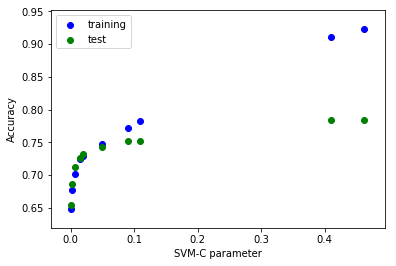

In [7]:
fname = "block5act_linSVM_4_19_2classes"
np.save("../plots/{}.npy".format(fname),np.column_stack([C_values,train_scores,test_scores]))
plt.scatter(C_values,train_scores,c='b',label='training')
plt.scatter(C_values,test_scores,c='g',label='test')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('SVM-C parameter')
plt.savefig("../plots/{}.png".format(fname))
plt.show()

In [8]:
# Examining one particular model
a = runLinSVMModel(dataset,0.42,len(dataset['y_train']),modeltype='linSVM')

[LibLinear]             precision    recall  f1-score   support

        0.0       0.70      1.00      0.82      1472
        1.0       1.00      0.89      0.94      5736

avg / total       0.94      0.91      0.92      7208

[[1472    0]
 [ 631 5105]]
             precision    recall  f1-score   support

        0.0       0.47      0.94      0.63       178
        1.0       0.98      0.75      0.85       735

avg / total       0.88      0.78      0.81       913

[[168  10]
 [187 548]]
Classification accuracy: 0.78
MSE: 0.22
Predictions correlation: 0.56


# Models on subset of three classes

In [4]:
# Loading in a dataset with a subset of all classes
subsetClasses = {2.0:0.0,3.0:1.0,5.0:2.0}
dataset = cu.datautils.loadDataset("../data/activations-4-19.h5",subsetClasses=subsetClasses)

Dim of data: 114688
Number of training images = 5736
Number of validation images = 1518
Number of test images = 735
Distribution in training data:
0 - 1431
1 - 2871
2 - 1434
Distribution in validation data:
0 - 406
1 - 742
2 - 370
Distribution in test data:
0 - 160
1 - 382
2 - 193


In [5]:
## Loading in and preparing datasets
x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']
num_val = dataset['x_val'].shape[0]
num_test = dataset['x_test'].shape[0]
nb_classes = 3

In [6]:
## Parameter search for SVM
C_values = 10**np.random.uniform(-3,0,10)
train_scores = []
test_scores = []
for C_val in C_values:
    a = runLinSVMModel(dataset,C_val,len(dataset['y_train']),printReports=False,modeltype='linSVM')
    train_scores.append(a['train_score'])
    test_scores.append(a['test_score'])
    print "Results for C={}:".format(C_val)
    print "Train score={}   Test score={}".format(a['train_score'],a['test_score'])

[LibLinear]Results for C=0.0108946427485:
Train score=0.767956764296   Test score=0.668027210884
[LibLinear]Results for C=0.150237995234:
Train score=0.990411436541   Test score=0.677551020408
[LibLinear]Results for C=0.00615729007402:
Train score=0.731171548117   Test score=0.665306122449
[LibLinear]Results for C=0.00173342051283:
Train score=0.676778242678   Test score=0.648979591837
[LibLinear]Results for C=0.378887936262:
Train score=0.999651324965   Test score=0.674829931973
[LibLinear]Results for C=0.0727500548646:
Train score=0.949616457462   Test score=0.672108843537
[LibLinear]Results for C=0.0303314581544:
Train score=0.851290097629   Test score=0.673469387755
[LibLinear]Results for C=0.461584464686:
Train score=1.0   Test score=0.67074829932
[LibLinear]Results for C=0.00528744674125:
Train score=0.724546722455   Test score=0.662585034014
[LibLinear]Results for C=0.525652364742:
Train score=1.0   Test score=0.67074829932


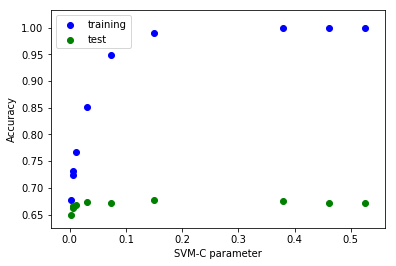

In [7]:
fname = "block5act_linSVM_4_19_3classes"
np.save("../plots/{}.npy".format(fname),np.column_stack([C_values,train_scores,test_scores]))
plt.scatter(C_values,train_scores,c='b',label='training')
plt.scatter(C_values,test_scores,c='g',label='test')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('SVM-C parameter')
plt.savefig("../plots/{}.png".format(fname))
plt.show()

In [10]:
# Examining one particular model
a = runLinSVMModel(dataset,0.99,len(dataset['y_train']),modeltype='linSVM')

[LibLinear]             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      1431
        1.0       1.00      1.00      1.00      2871
        2.0       1.00      1.00      1.00      1434

avg / total       1.00      1.00      1.00      5736

[[1431    0    0]
 [   0 2871    0]
 [   0    0 1434]]
             precision    recall  f1-score   support

        0.0       0.44      0.58      0.50       160
        1.0       0.74      0.65      0.69       382
        2.0       0.76      0.75      0.76       193

avg / total       0.68      0.66      0.67       735

[[ 93  54  13]
 [101 248  33]
 [ 16  32 145]]
Classification accuracy: 0.66
MSE: 0.46
Predictions correlation: 0.56


# Models on subset of classes - 4 classes

## Load in a subset of all classes 

In [4]:
# Loading in a dataset with a subset of all classes
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,5.0:3.0}
dataset = cu.datautils.loadDataset("../data/activations-5-16-block5-128*128.h5",subsetClasses=subsetClasses)


Dim of data: 8192
Number of training images = 7211
Number of validation images = 1832
Number of test images = 943
Distribution in training data:
0 - 1471
1 - 1419
2 - 2888
3 - 1433
Distribution in validation data:
0 - 343
1 - 376
2 - 723
3 - 390
Distribution in test data:
0 - 184
1 - 202
2 - 384
3 - 173


In [5]:
## Loading in and preparing datasets
x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']
num_val = dataset['x_val'].shape[0]
num_test = dataset['x_test'].shape[0]
nb_classes = 4

In [8]:
## Parameter search for SVM
C_values = 10**np.random.uniform(-1,0,10)
train_scores = []
test_scores = []
for C_val in C_values:
    a = runLinSVMModel(dataset,C_val,len(dataset['y_train']),printReports=False,modeltype='linSVM')
    train_scores.append(a['train_score'])
    test_scores.append(a['test_score'])
    print "Results for C={}:".format(C_val)
    print "Train score={}   Test score={}".format(a['train_score'],a['test_score'])

[LibLinear]Results for C=0.449277625485:
Train score=0.713215920122   Test score=0.517497348887
[LibLinear]Results for C=0.338766914188:
Train score=0.694078491194   Test score=0.513255567338
[LibLinear]Results for C=0.661679942986:
Train score=0.739009846069   Test score=0.516436903499
[LibLinear]Results for C=0.277150421565:
Train score=0.678962695881   Test score=0.511134676564
[LibLinear]Results for C=0.282163227017:
Train score=0.681181528221   Test score=0.510074231177
[LibLinear]Results for C=0.192140230541:
Train score=0.655248925253   Test score=0.515376458112
[LibLinear]Results for C=0.233162280441:
Train score=0.667868534184   Test score=0.517497348887
[LibLinear]Results for C=0.145670591:
Train score=0.639578421855   Test score=0.511134676564
[LibLinear]Results for C=0.133463675157:
Train score=0.634863403134   Test score=0.512195121951
[LibLinear]Results for C=0.138464087627:
Train score=0.636943558452   Test score=0.512195121951


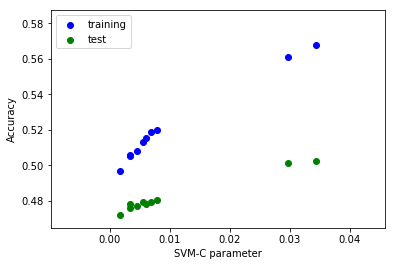

In [7]:
fname = "block5act_linSVM_128*128_4"
np.save("../plots/{}.npy".format(fname),np.column_stack([C_values,train_scores,test_scores]))
plt.scatter(C_values,train_scores,c='b',label='training')
plt.scatter(C_values,test_scores,c='g',label='test')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('SVM-C parameter')
plt.savefig("../plots/{}.png".format(fname))
plt.show()

In [12]:
a = runLinSVMModel(dataset,1e-1,len(dataset['y_train']),modeltype='linSVM')

[LibLinear]             precision    recall  f1-score   support

        0.0       0.62      1.00      0.77      1471
        1.0       0.92      0.90      0.91      1419
        2.0       1.00      0.74      0.85      2888
        3.0       0.94      0.87      0.90      1433

avg / total       0.89      0.85      0.86      7211

[[1466    0    0    5]
 [ 142 1273    0    4]
 [ 553  109 2151   75]
 [ 192    1    0 1240]]
             precision    recall  f1-score   support

        0.0       0.44      0.86      0.58       184
        1.0       0.53      0.51      0.52       202
        2.0       0.80      0.52      0.63       384
        3.0       0.64      0.53      0.58       173

avg / total       0.64      0.58      0.59       943

[[158   7   0  19]
 [ 45 103  42  12]
 [ 84  81 198  21]
 [ 71   4   6  92]]
Classification accuracy: 0.58
MSE: 1.50
Predictions correlation: 0.40


In [13]:
(a['train_score'],a['test_score'])

(0.85009014006379147, 0.58430540827147404)

In [40]:
10**np.random.uniform(-3,0,10)

array([ 0.0893849 ,  0.38330458,  0.00176971,  0.01411343,  0.76550141,
        0.00129565,  0.03611266,  0.00715768,  0.00149729,  0.11242027])

## Trying on block 3 activations

In [4]:
# Loading in a dataset with a subset of all classes
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,5.0:3.0}
dataset = cu.datautils.loadDataset("data/activations_block3_14_32.h5",subsetClasses=subsetClasses)

Dim of data: 114688
Number of training images = 7211
Number of validation images = 1832
Number of test images = 943
Distribution in training images: 
0 - 1471 
1 - 1419 
2 - 2888 
3 - 1433 
4 - 0
Distribution in validation images: 
0 - 343 
1 - 376 
2 - 723 
3 - 390 
4 - 0
Distribution in test images: 
0 - 184 
1 - 202 
2 - 384 
3 - 173 
4 - 0


In [5]:
## Parameter search for SVM
C_values = 10**np.random.uniform(-3,0,10)
train_scores = []
test_scores = []
for C_val in C_values:
    a = runLinSVMModel(dataset,C_val,len(dataset['y_train']),printReports=False,modeltype='linSVM')
    train_scores.append(a['train_score'])
    test_scores.append(a['test_score'])
    print "Results for C={}:".format(C_val)
    print "Train score={}   Test score={}".format(a['train_score'],a['test_score'])

[LibLinear]Results for C=0.00596952267023:
Train score=0.739287200111   Test score=0.551431601273
[LibLinear]Results for C=0.00847122286619:
Train score=0.796422132853   Test score=0.550371155885
[LibLinear]Results for C=0.00225396899692:
Train score=0.620857023991   Test score=0.511134676564
[LibLinear]Results for C=0.00939028985682:
Train score=0.813063375399   Test score=0.551431601273
[LibLinear]Results for C=0.00141996644246:
Train score=0.584523644432   Test score=0.499469777306
[LibLinear]Results for C=0.044495528721:
Train score=0.997781167661   Test score=0.583244962884
[LibLinear]Results for C=0.00533440845092:
Train score=0.71987241714   Test score=0.544008483563
[LibLinear]Results for C=0.0349104414101:
Train score=0.989599223409   Test score=0.585365853659
[LibLinear]Results for C=0.00382788130152:
Train score=0.67771460269   Test score=0.528101802757
[LibLinear]Results for C=0.021106196105:
Train score=0.939259464707   Test score=0.57051961824


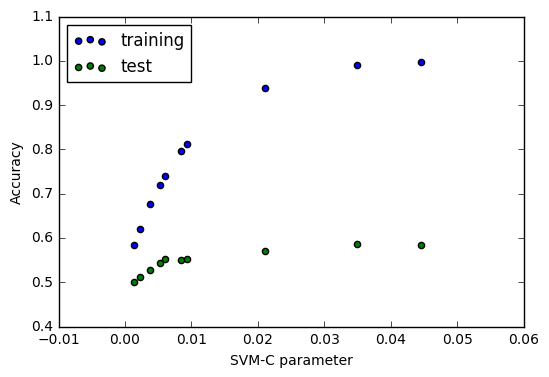

In [6]:
fname = "block3act_linSVM"
np.save("./plots/{}.npy".format(fname),np.column_stack([C_values,train_scores,test_scores]))
plt.scatter(C_values,train_scores,c='b',label='training')
plt.scatter(C_values,test_scores,c='g',label='test')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('SVM-C parameter')
plt.savefig("./plots/{}.png".format(fname))
plt.show()

In [12]:
with np.load("plots/block1act_linSVM.npy") as data_block1:
    C_values_block1 = data_block1[:,0]
    train_scores_block1 = data_block1[:,1]
    test_scores_block1 = data_block1[:,1]
    
with np.load("plots/block2act_linSVM.npy") as data_block1:
    C_values_block2 = data_block1[:,0]
    train_scores_block2 = data_block1[:,1]
    test_scores_block2 = data_block1[:,1]
    
with np.load("plots/block3act_linSVM.npy") as data_block1:
    C_values_block3 = data_block[:,0]
    train_scores_block3 = data_block1[:,1]
    test_scores_block3 = data_block1[:,1]

with np.load("plots/block4act_linSVM.npy") as data_block1:
    C_values_block4 = data_block1[:,0]
    train_scores_block4 = data_block1[:,1]
    test_scores_block4 = data_block1[:,1]
    
with np.load('plots/block5act_linSVM.npy') as data_block1:
    C_values_block5 = data_block1[:,0]
    train_scores_block5 = data_block1[:,1]
    test_scores_block5 = data_block1[:,1]

AttributeError: __exit__

In [ ]:

plt.scatter(C_values_block1,train_scores_block1,label='block1_training')
plt.scatter(C_values,test_scores_block1,label='block1_test')

plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('SVM-C parameter')
plt.savefig("./plots/{}.png".format(fname))
plt.show()

In [7]:
# Examining one particular model
a = runLinSVMModel(dataset,0.035,len(dataset['y_train']),modeltype='linSVM')

[LibLinear]             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98      1471
        1.0       1.00      1.00      1.00      1419
        2.0       1.00      0.98      0.99      2888
        3.0       1.00      1.00      1.00      1433

avg / total       0.99      0.99      0.99      7211

[[1471    0    0    0]
 [   0 1416    3    0]
 [  65    3 2819    1]
 [   0    0    0 1433]]
             precision    recall  f1-score   support

        0.0       0.46      0.99      0.63       184
        1.0       0.47      0.35      0.40       202
        2.0       0.71      0.50      0.59       384
        3.0       0.82      0.63      0.71       173

avg / total       0.63      0.59      0.58       943

[[182   1   0   1]
 [ 48  70  73  11]
 [102  79 191  12]
 [ 60   0   4 109]]
Classification accuracy: 0.59
MSE: 1.29
Predictions correlation: 0.51


## Trying on downsized 224x224 image activations

In [4]:
# Loading in a dataset with a subset of all classes
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,5.0:3.0}
dataset = cu.datautils.loadDataset("data/activations_b5_224x224_8.h5",subsetClasses=subsetClasses)

Dim of data: 25088
Number of training images = 7191
Number of validation images = 1875
Number of test images = 921
Distribution in training images: 
0 - 1438 
1 - 1451 
2 - 2845 
3 - 1457 
4 - 0
Distribution in validation images: 
0 - 355 
1 - 377 
2 - 767 
3 - 376 
4 - 0
Distribution in test images: 
0 - 205 
1 - 169 
2 - 383 
3 - 164 
4 - 0


In [5]:
## Parameter search for SVM
C_values = 10**np.random.uniform(-3,0,10)
train_scores = []
test_scores = []
for C_val in C_values:
    a = runLinSVMModel(dataset,C_val,len(dataset['y_train']),printReports=False,modeltype='linSVM')
    train_scores.append(a['train_score'])
    test_scores.append(a['test_score'])
    print "Results for C={}:".format(C_val)
    print "Train score={}   Test score={}".format(a['train_score'],a['test_score'])

[LibLinear]Results for C=0.0352547114141:
Train score=0.693366708385   Test score=0.619978284473
[LibLinear]Results for C=0.00378479331326:
Train score=0.607425949103   Test score=0.598262757872
[LibLinear]Results for C=0.0013845065397:
Train score=0.578083715756   Test score=0.580890336591
[LibLinear]Results for C=0.00222279650881:
Train score=0.590877485746   Test score=0.590662323561
[LibLinear]Results for C=0.452068371335:
Train score=0.861493533584   Test score=0.612377850163
[LibLinear]Results for C=0.00251581437448:
Train score=0.594075928244   Test score=0.592833876221
[LibLinear]Results for C=0.710742221034:
Train score=0.89806702823   Test score=0.604777415852
[LibLinear]Results for C=0.0841996289246:
Train score=0.7377277152   Test score=0.616720955483
[LibLinear]Results for C=0.115834182767:
Train score=0.755944931164   Test score=0.614549402823
[LibLinear]Results for C=0.418859582499:
Train score=0.854401335002   Test score=0.613463626493


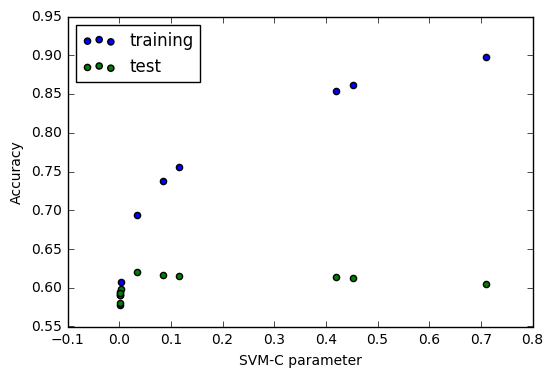

In [6]:
fname = "b5_224x224_8_linSVM"
np.save("./plots/{}.npy".format(fname),np.column_stack([C_values,train_scores,test_scores]))
plt.scatter(C_values,train_scores,c='b',label='training')
plt.scatter(C_values,test_scores,c='g',label='test')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('SVM-C parameter')
plt.savefig("./plots/{}.png".format(fname))
plt.show()

In [7]:
# Examining one particular model
a = runLinSVMModel(dataset,0.035,len(dataset['y_train']),modeltype='linSVM')

[LibLinear]             precision    recall  f1-score   support

        0.0       0.47      0.98      0.64      1438
        1.0       0.75      0.65      0.70      1451
        2.0       0.92      0.62      0.74      2845
        3.0       0.83      0.59      0.69      1457

avg / total       0.78      0.69      0.70      7191

[[1410    0    0   28]
 [ 332  948  119   52]
 [ 678  315 1759   93]
 [ 549    3   40  865]]
             precision    recall  f1-score   support

        0.0       0.48      0.98      0.64       205
        1.0       0.53      0.47      0.50       169
        2.0       0.85      0.55      0.67       383
        3.0       0.76      0.49      0.60       164

avg / total       0.69      0.62      0.62       921

[[200   0   0   5]
 [ 48  80  33   8]
 [ 94  67 210  12]
 [ 75   3   5  81]]
Classification accuracy: 0.62
MSE: 1.42
Predictions correlation: 0.48


### Fully connected network performance

In [9]:
valPred = cu.modelutils.evaluateSavedModel(\
                        "./savedModels/224x224_1024-256-256_4class_rmsproplr0.0001decay1e-06.hdf5",dataset,mode='val')

1875/1875 [==============================] - 1s     

Printing results on val dataset for best saved model: 

             precision    recall  f1-score   support

        0.0       0.47      0.86      0.61       355
        1.0       0.56      0.39      0.46       377
        2.0       0.70      0.63      0.66       767
        3.0       0.75      0.55      0.63       376

avg / total       0.64      0.61      0.60      1875

[[305   0  23  27]
 [ 65 147 149  16]
 [149 110 481  27]
 [128   4  39 205]]
Test accuracy: 0.61 


## Loading in images dataset

In [3]:
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,5.0:3.0}
dataset = cu.datautils.loadDataset("data/images_224x224_8.h5",scale=False,subsetClasses=subsetClasses)

Dim of data: 224
Number of training images = 7199
Number of validation images = 1854
Number of test images = 934
Distribution in training images: 
0 - 1471 
1 - 1428 
2 - 2877 
3 - 1423 
4 - 0
Distribution in validation images: 
0 - 349 
1 - 368 
2 - 755 
3 - 382 
4 - 0
Distribution in test images: 
0 - 178 
1 - 201 
2 - 363 
3 - 192 
4 - 0


In [4]:
valPred = cu.modelutils.evaluateSavedModel(\
                        "./savedModels/224x224_vgg_fine_tune_4class_rmsproplr1e-06decay1e-06.hdf5",dataset,mode='val')

Loaded in model..

Printing results on val dataset for best saved model: 



TypeError: Singleton array 3702 cannot be considered a valid collection.

005820


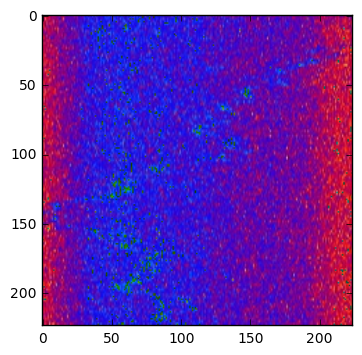

In [21]:
i = 10
print dataset['train_ids'][i]
plt.set_cmap('jet')
plt.imshow(dataset['x_train'][i])
plt.show()

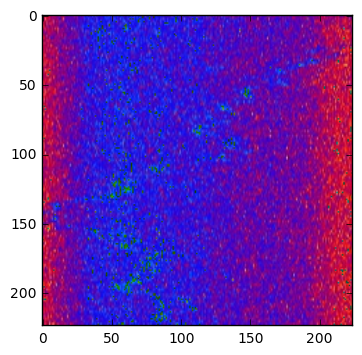

In [22]:
test = image.img_to_array(image.load_img('./data/specdataimages224x224_8/005820.jpg'))
plt.set_cmap('jet')
plt.imshow(test)
plt.show()

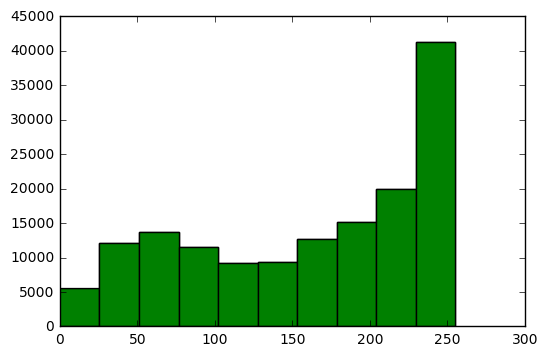

In [39]:
plt.hist(test.flatten())
plt.show()

In [26]:
np.min(test)

0.0